In [1]:
from somefunctions import *
augmented = False

C:\Users\nicol\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Configuration parameters
Easier if we put them all togheter

In [2]:
# Model parameters
pool_size = (2, 2)
train_shape = 400 #size of the training images
patch_size = 16
input_size = 64 # for now is the patch size
pad_size = int(input_size/2 - patch_size/2)


# Training parameters
reg = 1e-6  #regularization term
learning_rate = 0.001
nb_epoch = 20 #very small, only preliminary tests
batch_size = 150
steps_per_epoch = 250 #the number of training samples is huge, arbitrary value


# Data augmentation parameters
FLIP_FLAG = True # add random flips to the patches
ROTATION_FLAG = True # add random rotation to the patches


#Other stuff
NameWeights = 'pesi'
SubmissionName = 'SeriousSubmission.csv'

# Function to generate the minibatch + data augmentation
This function will be called during the training. <br>

In [3]:
def data_augmentation(X):
    '''Data augmentation on X, element of size (input_size * input_size * 3)'''
    #flip
    if FLIP_FLAG:
        flip_decision = np.random.choice(3)
        if flip_decision == 1:
            X = np.flipud(X)
        if flip_decision == 2: 
            X = np.fliplr(X)
    
    #rotate
    if ROTATION_FLAG:
        number_of_rotations = np.random.choice(3)
        X = np.rot90(X, number_of_rotations)

    #TODO: Brightness + constrast + saturation (?)
    
    return X

def generate_minibatch(X,Y):
    """
    Generate a minibatch
    """
    while 1:
        # Generate one minibatch
        X_batch = np.empty((batch_size, input_size, input_size, 3))
        Y_batch = np.empty(batch_size)
        low=input_size//2
        high = (train_shape + 2*pad_size - input_size//2)
        for i in range(batch_size):
            # Select a random image
            idx = np.random.choice(X.shape[0])
            
            x_coord = np.random.randint(low=low, high = high ) 
            y_coord = np.random.randint(low=low, high = high )
      
            X_temp = X[idx,x_coord - input_size//2:x_coord + input_size//2,
                           y_coord - input_size//2:y_coord + input_size//2]
            X_batch[i] = data_augmentation(X_temp)
            
            gt_temp = Y[idx,x_coord - patch_size//2:x_coord + patch_size//2,
                            y_coord - patch_size//2:y_coord + patch_size//2]            
            Y_batch[i] = patch_to_label(gt_temp)
            
        yield X_batch, Y_batch

# Train
Generate the model and train the dataset

In [4]:
def create_model():
    '''Create a sequential model'''        
    model = Sequential()
    
    # Conv
    model.add(Convolution2D(16, kernel_size=(5, 5), 
                            input_shape = ( input_size, input_size, 3),
                            padding = 'SAME'))
    model.add(LeakyReLU(alpha=0.1))
    
    # Conv + pooling
    model.add(Convolution2D(32, kernel_size=(5, 5),
                            padding = 'SAME'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=pool_size, padding = 'SAME'))
    
    # Dropout
    model.add(Dropout(0.25))
    
    # Conv
    model.add(Convolution2D(64, kernel_size=(3, 3),
                                padding = 'SAME'))
    model.add(LeakyReLU(alpha=0.1))
    
    # Conv + pooling
    model.add(Convolution2D(128, kernel_size=(3, 3),
                                padding = 'SAME'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=pool_size, padding = 'SAME'))
    
    # Dropout
    model.add(Dropout(0.25))
    
    # Flatten
    model.add(Flatten())
    
    # Dense layer
    model.add(Dense(512, activation='relu'))
    
    # Dense layer          
    model.add(Dense(256, activation='relu'))
    
    # Output          
    model.add(Dense(units = 1, activation = 'sigmoid'))

    #Optimizer          
    opt = Adam(lr=learning_rate) # Adam optimizer with default initial learning rate
 

    # This callback reduces the learning rate when the training accuracy does not improve any more
    lr_callback = ReduceLROnPlateau(monitor='acc', factor=0.5, patience=5,
                                    verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    # Stops the training process upon convergence
    stop_callback = EarlyStopping(monitor='acc', min_delta=0.0001, patience=11, verbose=1, mode='auto')
    
    model.compile(loss=binary_crossentropy,
                  optimizer=opt,
                  metrics=['acc'])
    
    return model, stop_callback, lr_callback

    

def train(X, Y):    
    '''
    Generate an instance of the model an train the model on X, Y
    '''
    print('Training set shape: ', X.shape) 
    print(f'Batch_size: {batch_size} \nSteps per epoch: {steps_per_epoch} \n')
    
    
    model, stop_callback, lr_callback = create_model()
    
    np.random.seed(20122018) # Reproducibility + remember the deadline is the 20.12.2018
    
    try:
        model.fit_generator(generate_minibatch(X,Y),
                            steps_per_epoch=steps_per_epoch,
                            nb_epoch=nb_epoch,
                            verbose=1,
                            callbacks=[lr_callback, stop_callback])
    except KeyboardInterrupt:
        print('\n\nKeyboard interruption!\n\n')
        pass
    

    model.save_weights(NameWeights)
    
    print(f'Training completed, weights saved in: {NameWeights}')
    
    return model

# Load images

In [5]:
# Load a set of image
root_dir = "../Data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files) 
print("Loading " + str(n) + " images")
imgs_original = [load_image(image_dir + files[i]) for i in range(n)]
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
gt_imgs_not_padded = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


# Preprocessing on the whole images

Simply padding

In [6]:
imgs = padding_imgs(np.array(imgs),pad_size)
gt_imgs = padding_GT(np.array(gt_imgs),pad_size)

# Training

# split in validation + train

(VERY BASIC!) In this way we can check directly what happens in the validation set

In [7]:
N = imgs.shape[0]
ratio = 0.8
N_train = int(N*ratio)
N_valid = int(N - N*ratio)
X_train = imgs[:N_train]
X_valid = imgs[N-N_valid:]
Y_train = gt_imgs[:N_train]

In [8]:
print(X_train.shape)
print(X_valid.shape)
print(X_train.shape[0] + X_valid.shape[0])

(80, 448, 448, 3)
(20, 448, 448, 3)
100


In [9]:
model = train(X_train,Y_train)

Training set shape:  (80, 448, 448, 3)
Batch_size: 150 
Steps per epoch: 250 



C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=250, verbose=1, callbacks=[<keras.ca..., epochs=20)`


Epoch 1/20
250/250 [==============================] - 1123s 4s/step - loss: 0.5110 - acc: 0.7541
Epoch 2/20
250/250 [==============================] - 1223s 5s/step - loss: 0.3776 - acc: 0.8246
Epoch 3/20
250/250 [==============================] - 1096s 4s/step - loss: 0.2921 - acc: 0.8746
Epoch 4/20
250/250 [==============================] - 1091s 4s/step - loss: 0.2401 - acc: 0.8979
Epoch 5/20
250/250 [==============================] - 1086s 4s/step - loss: 0.2239 - acc: 0.9053
Epoch 6/20
250/250 [==============================] - 1084s 4s/step - loss: 0.2087 - acc: 0.9126
Epoch 7/20
250/250 [==============================] - 1083s 4s/step - loss: 0.2032 - acc: 0.9142
Epoch 8/20
250/250 [==============================] - 1081s 4s/step - loss: 0.1905 - acc: 0.9199
Epoch 9/20
250/250 [==============================] - 1082s 4s/step - loss: 0.1806 - acc: 0.9240
Epoch 10/20
250/250 [==============================] - 1088s 4s/step - loss: 0.1854 - acc: 0.9229
Epoch 11/20
250/250 [========

# Check if on the train set we have good results

In [10]:
def imgs_to_windows(imgs, img_size, patch_size, window_size):
    ''' Takes padded images and outputs an array with the windows'''
    windows = []
    for idx in range(imgs.shape[0]):
        im = imgs[idx]
        for i in range(img_size//patch_size):
            for j in range(img_size//patch_size):
                temp = im[j*patch_size:window_size + j*patch_size,
                                  i*patch_size:window_size + i*patch_size]
                windows.append(temp)
    return np.asarray(windows)


In [11]:
def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

In [12]:
IDX = 1
X = imgs_to_windows(imgs,400,patch_size,input_size)
patches_idx = X[625*IDX:625*(IDX+1)]

print(X.shape)
print(patches_idx.shape)

(62500, 64, 64, 3)
(625, 64, 64, 3)


In [13]:
Z_idx = model.predict(patches_idx)
labels_idx = (Z_idx > 0.5) *1 
print(Z_idx[:3])    

[[1.77380798e-06]
 [1.09756875e-05]
 [2.82569772e-06]]


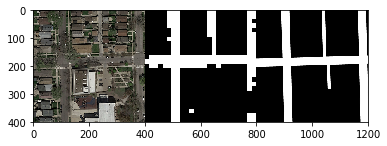

In [14]:
predicted_image = label_to_img(400,400,16,16,labels_idx)
temp = concatenate_images(imgs_original[IDX],predicted_image)
plt.imshow(concatenate_images(temp, gt_imgs_not_padded[IDX]))

# Check what happens on the validation set

In [15]:
# Recover the weights without training everything again
model,_,_ = create_model()
model.load_weights(NameWeights)

In [16]:
#create the input for the model
val_inputs = imgs_to_windows(X_valid,400,patch_size,input_size)
print(val_inputs.shape)

(12500, 64, 64, 3)


In [17]:
#get the true value of the labels
Y_valid = gt_imgs_not_padded[N-N_valid:]
val_gt_patches = [img_crop(Y_valid[i], patch_size, patch_size) for i in range(N_valid)]
val_gt_patches =  np.asarray([val_gt_patches[i][j] for i in range(len(val_gt_patches)) for j in range(len(val_gt_patches[i]))])
val_true_labels = np.asarray([value_to_class(np.mean(val_gt_patches[i])) for i in range(len(val_gt_patches))])
print(val_true_labels.shape)

(12500,)


In [18]:
#predict
val_prediction = model.predict(val_inputs)
print(val_prediction[0:3])

[[0.00023038]
 [0.00063308]
 [0.01620427]]


In [19]:
# compute the metrics
from sklearn.metrics import f1_score
val_predicted_labels = ( (val_prediction < 0.5) * 1 ).flatten()
val_accuracy = np.sum(np.abs(val_predicted_labels - val_true_labels))/val_true_labels.shape[0]
print('Accuracy on validation set is: ', val_accuracy)
print('F1 score on validation set is:', f1_score(val_true_labels,val_predicted_labels))

Accuracy on validation set is:  0.89488
F1 score on validation set is: 0.1362162162162162


# predict on test

In [20]:
#load images and pad them
test_images = np.asarray(pick_test_images())

test_images = padding_imgs(np.array(test_images),pad_size)

test_images_not_padded = np.asarray(pick_test_images())

In [21]:
#prepare the input for the prediction
test_inputs = imgs_to_windows(test_images,608,patch_size,input_size)
print(test_inputs.shape)

(72200, 64, 64, 3)


In [22]:
#recover the model
model, _,_ = create_model()
model.load_weights(NameWeights)

In [23]:
#predict
test_prediction = model.predict(test_inputs)
print(test_prediction[0:3])

[[0.28335866]
 [0.99591947]
 [0.996021  ]]


In [24]:
test_predicted_labels = ( (test_prediction > 0.5) * 1 ).flatten()
test_labels = test_predicted_labels.reshape(50,-1)
print('Every row contains the labels of one image')
print(test_labels.shape)

Every row contains the labels of one image
(50, 1444)


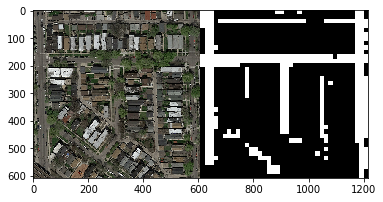

In [25]:
#check the prediction on the image IDX
IDX = 9 
im = label_to_img(608, 608, 16, 16, test_labels[IDX])
plt.imshow(concatenate_images(test_images_not_padded[IDX], im))

In [26]:
MY_masks_to_submission(SubmissionName, test_labels)